<div class="alert alert-info"><h1>Using Logistic Regression to Predict the 2020 Maricopa County Election Results by Geometric Coordinates</h1></div>

# Table of Contents
* [1.Extract and wrangle all datasets](#chapter1)
    * [Install and import Libraries](#section_1_1)
    * [2020 Election Results](#section_1_2)
    * [2016, 2012, and 2008 Election Results](#section_1_3)
    * [Put all results together into a single dataframe](#section_1_4)
    * [Extract and wrangle geometric points](#section_1_5)
* [2.Create geometric points](#chapter2)
* [3.Merge geometric points with historical voting results](#chapter3)
    * [2020](#section_3_1)
    * [2016](#section_3_2)
    * [2012](#section_3_3)
    * [2008](#section_3_4)
    * [Create the master file](#section_3_5)
* [4.Train and Test a Logistic Regression model](#chapter4)
    * [Linearity check](#section_4_1)
    * [Train and test model](#section_4_3)
    * [Check results](#section_4_4)
* [5.Create random "guesses" (randomly generated election results)](#chapter5)
* [6.Export CSV of Results (deliverable 1)](#chapter6)
* [7.Statistical Analysis](#chapter7)
    * [Hypothesis](#section_7_1)
    * [Proportions z-test](#section_7_2)
    * [Statistical test results](#section_7_3)
* [8.Investigate Results](#chapter8)
    * [Map plot of inaccurate results](#section_8_1)
    * [Map plot of inaccurate results - historical elections](#section_8_2)
    * [Map plot of inaccurate results - historical elections - urban center](#section_8_3)
    * [Animated map of all election results](#section_8_4)
* [9.Conclusion](#chapter9)

<div class="alert alert-info"><h1>1. Extract and wrangle all datasets</h1></div> <a class="anchor" id="chapter1"></a>

<div class="alert alert-success"><h3>Install and import libraries</h3></div> <a class="anchor" id="section_1_1"></a>

In [124]:
#we have installed geopandas below, but have commented out the code since this notebook will be shared with WGU faculty 
#it is good manners to comment out code that installs packages or libraries before sharing the file
#!pip install geopandas

In [125]:
#below we also install contextily for our background roadmaps
#!pip3 install contextily

In [126]:
#import the necessary scraping and processing libraries
import xml.etree.ElementTree as ET
import csv
import pandas as pd
import numpy as np

#import the necessary plotting library
import matplotlib.pyplot as plt
%matplotlib inline

#import libraries needed for animation plots
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Button

#import the necessary geographic libraries
import geopandas as gpd
from shapely.geometry import MultiLineString, LineString, MultiPoint, Point, MultiPolygon, Polygon
import contextily as cx

#import the necessary machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

#import the necessary statistical libraries
from scipy.stats import pearsonr
from statsmodels.stats.proportion import proportions_ztest

<div class="alert alert-success"><h3>2020 Results. (XML data)</h3></div> <a class="anchor" id="section_1_2"></a>
The 2020 results file is stored as an XML file. To extract the data I need, I will be using the xml.etree.ElementTree library, which makes parsing XML data easier.

In [127]:
# Specify the path to the XML file
xml_file_path = 'Maricopa County Election Results Files/Results.Detail_2020General.xml'

# Parse the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()


In [128]:
#extract the xml data and insert into a dataframe
columns = ['Contest', 'Choice', 'Total Votes', 'Jurisdiction', 'Votes in Jurisdiction', 'Precinct', 'Votes in Precinct', 'Vote Type', 'Votes for Vote Type']
data = []

# Iterate over contests
for contest in root.findall('.//contests/contest'):
    contest_name = contest.get('contestLongName')
    if contest_name == 'President of the United States':

        # Iterate over choices
        for choice in contest.findall('.//choices/choice'):
            choice_name = choice.get('choiceName')
            total_votes = choice.get('totalVotes')

            # Iterate over jurisdictions for each choice
            for jurisdiction in choice.findall('.//jurisdictions/jurisdiction'):
                jurisdiction_name = jurisdiction.get('name')
                if jurisdiction_name == 'Maricopa':
                    votes_in_jurisdiction = jurisdiction.get('votes')

                    # Iterate over precincts for each jurisdiction
                    for precinct in jurisdiction.findall('.//precincts/precinct'):
                        precinct_name = precinct.get('name')
                        votes_in_precinct = precinct.get('votes')

                        # Iterate over vote types for each precinct
                        for vote_type in precinct.findall('.//voteTypes/voteType'):
                            vote_type_name = vote_type.get('voteTypeName')
                            votes_for_vote_type = vote_type.get('votes')
                            
                             # Append data to the list
                            data.append([contest_name, choice_name, total_votes, jurisdiction_name, votes_in_jurisdiction, precinct_name, votes_in_precinct, vote_type_name, votes_for_vote_type])

# Create 2020 results DataFrame
df = pd.DataFrame(data, columns=columns)


In [129]:
# Display the DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17832 entries, 0 to 17831
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Contest                17832 non-null  object
 1   Choice                 17832 non-null  object
 2   Total Votes            17832 non-null  object
 3   Jurisdiction           17832 non-null  object
 4   Votes in Jurisdiction  17832 non-null  object
 5   Precinct               17832 non-null  object
 6   Votes in Precinct      17832 non-null  object
 7   Vote Type              17832 non-null  object
 8   Votes for Vote Type    17832 non-null  object
dtypes: object(9)
memory usage: 1.2+ MB


In [130]:
#inspect the dataframe
df[df.Precinct == '0001 ACACIA'].head(5)

,Contest,Choice,Total Votes,Jurisdiction,Votes in Jurisdiction,Precinct,Votes in Precinct,Vote Type,Votes for Vote Type
0,President of the United States,"Biden, Joseph",1672143,Maricopa,1040774,0001 ACACIA,1770,Polling Place,134
1,President of the United States,"Biden, Joseph",1672143,Maricopa,1040774,0001 ACACIA,1770,Early Ballots,1621
2,President of the United States,"Biden, Joseph",1672143,Maricopa,1040774,0001 ACACIA,1770,Provisional Ballots,15
2229,President of the United States,"Boddie, President R.",13,Maricopa,10,0001 ACACIA,0,Polling Place,0
2230,President of the United States,"Boddie, President R.",13,Maricopa,10,0001 ACACIA,0,Early Ballots,0


In [131]:
# Convert the votes to numeric data type
numeric_columns = ['Votes in Precinct']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17832 entries, 0 to 17831
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Contest                17832 non-null  object
 1   Choice                 17832 non-null  object
 2   Total Votes            17832 non-null  object
 3   Jurisdiction           17832 non-null  object
 4   Votes in Jurisdiction  17832 non-null  object
 5   Precinct               17832 non-null  object
 6   Votes in Precinct      17832 non-null  int64 
 7   Vote Type              17832 non-null  object
 8   Votes for Vote Type    17832 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.2+ MB


In [132]:
#drop unnecessary columns
df_2020 = df.drop(['Vote Type', 'Votes for Vote Type', 'Total Votes', 'Jurisdiction', 'Votes in Jurisdiction'], axis='columns')
#remove duplicate lines, as we only need the first row for each candidate
df_2020.drop_duplicates(subset=['Contest', 'Precinct', 'Choice'], inplace=True)

In [133]:
#create Democratic, Republican, and Other column based on candidate name
conditions = [
    df_2020['Choice'].str.contains('Biden', case=False),
    df_2020['Choice'].str.contains('Trump', case=False),
    ~df_2020['Choice'].str.contains('Biden|Trump', case=False),  # Check if it does not contain Biden nor Trump
]

values = ['Democratic', 'Republican', 'Other']

# Use numpy.select to create the new 'Party' column
df_2020['Party'] = np.select(conditions, values, default='Other')

In [134]:
#view results for 1 precinct, after changes
df_2020[df_2020.Precinct == '0001 ACACIA']

,Contest,Choice,Precinct,Votes in Precinct,Party
0,President of the United States,"Biden, Joseph",0001 ACACIA,1770,Democratic
2229,President of the United States,"Boddie, President R.",0001 ACACIA,0,Other
4458,President of the United States,"Cummings, Daniel Clyde",0001 ACACIA,0,Other
6687,President of the United States,"Hawkins, Howie",0001 ACACIA,0,Other
8916,President of the United States,"Jorgensen, Jo",0001 ACACIA,61,Other
11145,President of the United States,"La Riva, Gloria",0001 ACACIA,0,Other
13374,President of the United States,"Simmons, Jade",0001 ACACIA,0,Other
15603,President of the United States,"Trump, Donald J.",0001 ACACIA,1475,Republican


In [135]:
# Create a pivot table to line up data as we need it
df_2020 = pd.pivot_table(df_2020, 
                          index='Precinct',
                          columns='Party',
                          values='Votes in Precinct',
                          aggfunc='sum',
                          fill_value=0)

# Reset the index to make it look like a regular DataFrame
df_2020.reset_index(inplace=True)


In [136]:
#create the election year column
df_2020['Election Year'] = 2020

In [137]:
#inspect the formatted 2020 dataframe
df_2020.head(5)

Party,Precinct,Democratic,Other,Republican,Election Year
0,0001 ACACIA,1770,61,1475,2020
1,0002 ACOMA,1029,45,1788,2020
2,0003 ACUNA,1655,13,328,2020
3,0004 ADOBE,875,44,1192,2020
4,0005 ADORA,2853,91,4067,2020


<div class="alert alert-success"><h3>2016, 2012, and 2008 Results (CSV data)</h3></div> <a class="anchor" id="section_1_3"></a>

In [138]:
#open files and store in lists
data_16 = []
with open('Maricopa County Election Results Files/2016Maricopa.txt', 'r', newline='', encoding='ISO-8859-1') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        data_16.append(row)
        
data_12 = []
with open('Maricopa County Election Results Files/2012Maricopa.txt', 'r', newline='', encoding='ISO-8859-1') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        data_12.append(row)
        
data_08 = []
with open('Maricopa County Election Results Files/2008Maricopa.txt', 'r', newline='', encoding='ISO-8859-1') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        data_08.append(row)

In [139]:
#convert lists to pandas dataframes
df_16 = pd.DataFrame(data_16[1:], columns=data_16[0])
df_12 = pd.DataFrame(data_12[1:], columns=data_12[0])
df_08 = pd.DataFrame(data_08[1:], columns=data_08[0])

In [140]:
#create an Election Year column
df_16['Election Year'] = 2016
df_12['Election Year'] = 2012
df_08['Election Year'] = 2008

In [141]:
#concatenate the 2016, 2012, and 2008 dataframes into 1 single dataframe
append_df = pd.concat([df_16, df_12, df_08])

In [142]:
#inspect the concatenated dataframe
append_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460767 entries, 0 to 197510
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   PRECINCT_NAME        460767 non-null  object
 1   CANDIDATE_FULL_NAME  460767 non-null  object
 2   contest_party_id     460767 non-null  object
 3   candidate_party_id   460767 non-null  object
 4   CONTEST_TYPE         460767 non-null  object
 5   contest_id           460767 non-null  object
 6   CONTEST_ORDER        460767 non-null  object
 7   CANDIDATE_ORDER      460767 non-null  object
 8   CONTEST_FULL_NAME    460767 non-null  object
 9   TOTAL                460767 non-null  object
 10  PRECINCT_ID          460767 non-null  object
 11  precinct_order       460767 non-null  object
 12  contest_vote_for     460767 non-null  object
 13  PROCESSED_DONE       460767 non-null  object
 14  PROCESSED_STARTED    460767 non-null  object
 15  CONTEST_TOTAL        460767 non-nu

In [143]:
#drop the columns we don't need
append_df = append_df.drop(['PRECINCT_ID', 'precinct_order', 'contest_vote_for', 'PROCESSED_DONE', 'PROCESSED_STARTED', 'undervote', 'overvote','contest_party_id', 'candidate_party_id', 'CONTEST_TYPE', 'contest_id', 'CONTEST_ORDER', 'CANDIDATE_ORDER', 'CONTEST_TOTAL', 'IS_WRITEIN'], axis='columns')

In [144]:
#rename columns to match to the 2020 dataframe
append_df.rename(columns={"PRECINCT_NAME": "Precinct", "CANDIDATE_FULL_NAME": "Choice", "CONTEST_FULL_NAME": "Contest", "TOTAL": "Total Precinct Votes for Candidate"}, inplace=True)

In [145]:
# Convert the relevant columns to numeric
numeric_columns = ['Total Precinct Votes for Candidate']
append_df[numeric_columns] = append_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
append_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460767 entries, 0 to 197510
Data columns (total 5 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Precinct                            460767 non-null  object
 1   Choice                              460767 non-null  object
 2   Contest                             460767 non-null  object
 3   Total Precinct Votes for Candidate  460767 non-null  int64 
 4   Election Year                       460767 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 21.1+ MB


In [146]:
# Create choice dataframe for only Presidential elections
choice_df = append_df[append_df.Contest.str.contains("President", case=False)]

In [147]:
#inspect the dataframe
choice_df[choice_df['Election Year'] == 2016].head(5)

,Precinct,Choice,Contest,Total Precinct Votes for Candidate,Election Year
4,0001 ACACIA,REP - TRUMP PENCE,Presidential Electors,1156,2016
5,0001 ACACIA,DEM - CLINTON KAINE,Presidential Electors,1144,2016
6,0001 ACACIA,LBT - JOHNSON WELD,Presidential Electors,133,2016
7,0001 ACACIA,GRN - STEIN BARAKA,Presidential Electors,45,2016
8,0001 ACACIA,Write-In Candidate,Presidential Electors,52,2016


In [148]:
# Create a copy of the DataFrame using .copy()
choice_df = choice_df.copy()

#create Democratic, Republican, and Other column based on candidate name
conditions_2 = [
    choice_df['Choice'].str.contains('DEM', case=False),
    choice_df['Choice'].str.contains('REP', case=False),
#if column does not contain either Rep or Dem
    ~choice_df['Choice'].str.contains('DEM|REP', case=False),  
]

values = ['Democratic', 'Republican', 'Other']

# Use numpy.select to create the new 'Party' column
choice_df['Party'] = np.select(conditions_2, values, default='Other')

In [149]:
# Create a pivot table
df_08_12_16 = pd.pivot_table(choice_df, 
                          index=['Precinct', 'Election Year'],
                          columns='Party',
                          values='Total Precinct Votes for Candidate',
                          aggfunc='sum',
                          fill_value=0)

# Reset the index to make it look like a regular DataFrame
df_08_12_16.reset_index(inplace=True)

In [150]:
#inspect the dataframe
df_08_12_16[df_08_12_16['Election Year'] == 2012].head(5)

Party,Precinct,Election Year,Democratic,Other,Republican
18,001 ACACIA,2012,1046,75,1156
39,002 ACOMA,2012,658,34,1472
60,003 ACUNA,2012,1133,24,169
81,004 ADOBE,2012,546,30,868
102,005 AGUA FRIA,2012,343,16,686


<div class="alert alert-success"><h3>Put all results together into a single dataframe</h3></div> <a class="anchor" id="section_1_4"></a>

In [151]:
#combine the all election years into 1 dataframe
results_df = pd.concat([df_2020, df_08_12_16])

In [152]:
#split the precinct name and number into 2 columns and then strip of extra whitespace
results_df[['Precinct Number', 'Precinct']] = results_df['Precinct'].str.split(' ', n=1, expand=True)
results_df['Precinct'] = results_df['Precinct'].str.strip()

In [153]:
#inspect the dataframe
results_df.head(5)

Party,Precinct,Democratic,Other,Republican,Election Year,Precinct Number
0,ACACIA,1770,61,1475,2020,0001
1,ACOMA,1029,45,1788,2020,0002
2,ACUNA,1655,13,328,2020,0003
3,ADOBE,875,44,1192,2020,0004
4,ADORA,2853,91,4067,2020,0005


In [154]:
# Define a list of unique precincts where Election Year is 2020 - we use this to verify that the geodataframe 
#has all of the precincts from the election results dataframe
list_of_precincts = results_df[results_df['Election Year'] == 2020]['Precinct'].unique()


<div class="alert alert-success"><h3>Extract and wrangle geometric points</h3></div> <a class="anchor" id="section_1_5"></a>

Voting precincts change every 10 years, in alignment with the results of the Federal Census. This makes overlapping results year-over-year rather difficult, as the boundaries of the voting precincts fluctuate, meaning you are not comparing apples to apples in historical data comparisons. The differences can be subtle and they can also be substantial. 

Instead, this program will take shapefiles containing precinct boundary geocoordinates, then calculate the geocoordinates between the boundaries to create a mesh that can then be linked to the election results data, year over year, to determine how that point on the map voted in each election. 

Our analysis and predictive model will be based on these points, rather than the shifting boundaries of the precincts themselves. 

In [155]:
#store the file in a geo dataframe
precincts_20 = gpd.read_file('Maricopa County Precinct GeoJSON Files/Maricopa_County_Voting_Precincts_(2018-2021).geojson')

Below we can see the map of Maricopa County and the voting precinct boundaries. The larger precincts are rural areas on the outer edges of the county. The Independent Redistricting Commission attempts to divide up the county precincts based on voter registration counts, making the precinct proportional in representation though not necessarily in size. You will see the effect of this in the below plot, which shows far more precincts within the urban core of the county (towards the center of the plot) than in the more rural, outer edges of the county. 

<Axes: >

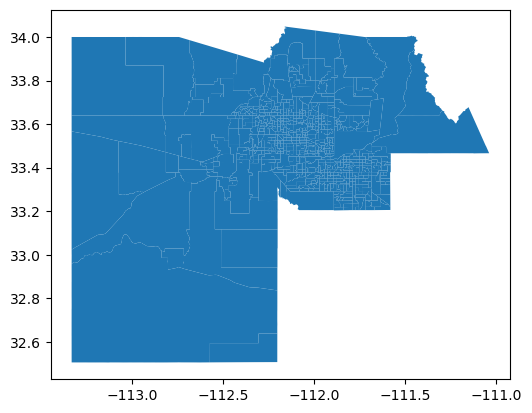

In [156]:
#view the file's plot
precincts_20.plot()

In [157]:
#inspect the content of the geodataframe
precincts_20.head(5)

,OBJECTID,BdType,BdVal,PctNum,SupervisorDistrict,LegislativeDistrict,CongressionalDistrict,CollegeDistrict,JusticePrecinct,BdName,SHAPE_Length,SHAPE_Area,geometry
0,1,P,0377,377.0,2,15,6,2,25,LONE MOUNTAIN,0.226548,0.001824,"MULTIPOLYGON (((-111.96073 33.79740, -111.9607..."
1,2,P,0677,677.0,3,1,8,3,11,TRAMONTO,0.253714,0.001520,"MULTIPOLYGON (((-112.10015 33.82743, -112.1001..."
2,3,P,0180,180.0,3,1,8,3,11,DESERT HILLS,0.278543,0.003015,"MULTIPOLYGON (((-112.03910 33.87171, -112.0315..."
3,4,P,0095,95.0,3,15,6,3,25,CAVE BUTTES,0.203483,0.001805,"MULTIPOLYGON (((-112.01145 33.72148, -112.0160..."
4,5,P,0356,356.0,1,17,5,1,3,LANTANA CANYON,0.141055,0.000784,"MULTIPOLYGON (((-111.84122 33.24761, -111.8412..."


Below we are going to extract and store the original boundary coordinates for every precinct in Maricopa County. 

In [158]:
#here we will iterate through the multipolygons in the GeoJSON file to find the individual polygons, then the individual
#longitude and latitude coordinates, stored in objects called "points"

#create dictionary to store the individual points from the lines and associate them to the precinct names
og_points = {}

for _, row in precincts_20.iterrows():
    precinct = row['BdName']
    geometry = row['geometry']
    
    if geometry.geom_type == 'MultiPolygon':
        multi_polygon = MultiLineString([LineString(poly.exterior.coords) for poly in geometry.geoms])

        if precinct not in og_points:
            og_points[precinct] = []

        for line in multi_polygon.geoms:
            for point in line.coords:
                og_points[precinct].append(Point(point))



To demonstrate, below is a single voting precinct with its boundary coordinates displayed as red dots.

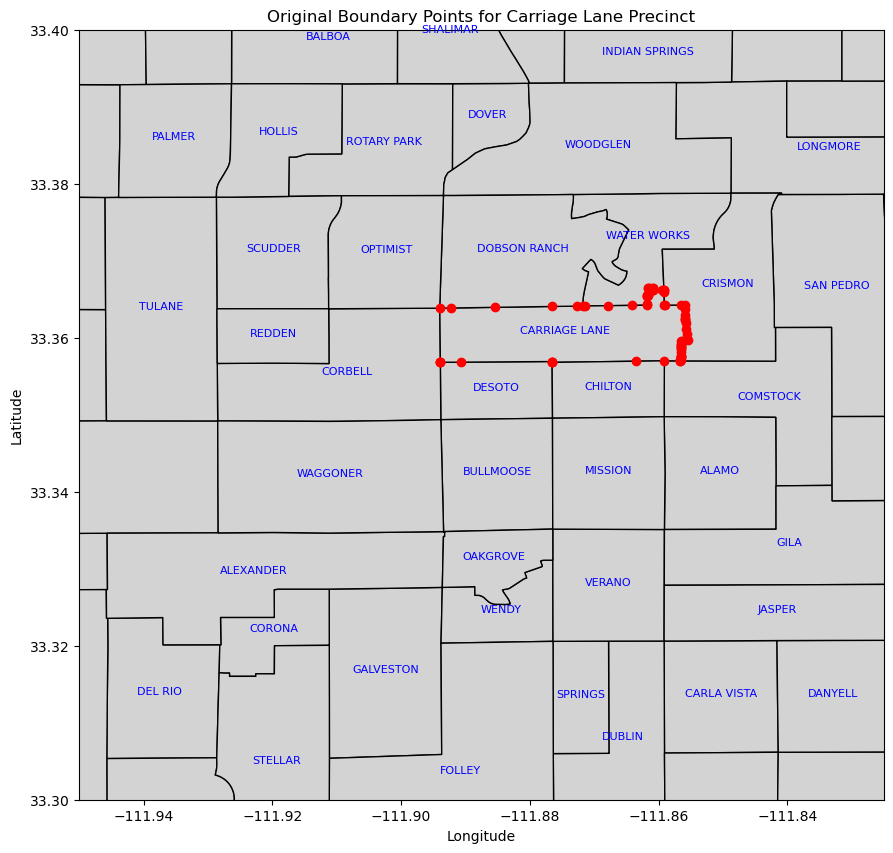

In [159]:
# Create an empty MultiPoint object to store all the points
og_points_MP = MultiPoint()

# Iterate over the points in the dictionary and add them to the MultiPoint
for precinct, precinct_points in og_points.items():
    if precinct == 'CARRIAGE LANE':  # targeting 1 specific precinct for demonstrative purposes only
        og_points_MP = og_points_MP.union(MultiPoint([Point(coord) for coord in precinct_points]))

# Plot GeoDataFrame
ax = precincts_20.plot(figsize=(12, 10), color='lightgray', edgecolor='black')

# Plot all points
for point in og_points_MP.geoms:
    plt.scatter(point.x, point.y, color='red', label='All Points')
    
# Annotate precincts
for index, row in precincts_20.iterrows():
    plt.annotate(row['BdName'], (row.geometry.centroid.x, row.geometry.centroid.y),
                 color='blue', fontsize=8, ha='center')
    
# Set x and y axis limits
plt.xlim(-111.95, -111.825)  
plt.ylim(33.3, 33.4)  

# Set labels and show the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Original Boundary Points for Carriage Lane Precinct')

# Show the plot
plt.show()



<div class="alert alert-info"><h1>2. Generate geometric points</h1></div> <a class="anchor" id="chapter2"></a>

Now we will create calculated points -within- each 2020 precinct. This allows us to create a "mesh" of coordinates across the entire county, which we can then reference to prior election year shapefiles to determine which precinct each point belonged to in each election year.

We only need to do this generation for the 2020 boundaries, as we want only 1 set of static coordinates to overlap with historical precinct boundaries. We do not want to generate new internal coordinates for each election year, as this would defeat our intention. 

In [160]:
#define a function to generate a mesh of coordinates within the boundaries of the precincts
def generate_points_within_polygon(polygon, n_points=10):
    """
    Generate a mesh of coordinates within the boundaries of the given polygon.

    Parameters:
    - polygon (shapely.geometry.Polygon or shapely.geometry.MultiPolygon): The polygon for which to generate points.
    - n_points (int, optional): The number of points to generate along each axis. Defaults to 10.

    Returns:
    - list of shapely.geometry.Point: A list of generated points within the specified polygon.

    This function generates a mesh of coordinates within the bounding box of the input polygon.
    The bounding box is divided into a grid, and points are generated at the intersections of the grid lines.
    The generated points that fall within the polygon's boundaries are returned in a list.

    Example:
    >>> polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
    >>> generate_points_within_polygon(polygon, n_points=5)
    [Point(0.0, 0.0), Point(0.25, 0.25), Point(0.5, 0.5), Point(0.75, 0.75), Point(1.0, 1.0)]
    """
    
    minx, miny, maxx, maxy = polygon.bounds
    x_coords = np.linspace(minx, maxx, n_points)
    y_coords = np.linspace(miny, maxy, n_points)

    gen_points = []
    for x in x_coords:
        for y in y_coords:
            gen_point = Point(x, y)
            if gen_point.within(polygon):
                gen_points.append(gen_point)

    return gen_points

In [161]:
#create a dictionary to link precinct names to the generated points
gen_points_dict = {}

# Iterate over rows and generate points within each polygon, using the function in the cell above
for index, row in precincts_20.iterrows():
    
    precinct = row['BdName']
    geometry = row['geometry']

    if geometry.geom_type == 'MultiPolygon':

        if precinct not in gen_points_dict:
            gen_points_dict[precinct] = []
            
        for polygon in geometry.geoms:
            points_within_polygon = generate_points_within_polygon(polygon)
                
            for point in points_within_polygon:
                gen_points_dict[precinct].append(Point(point))
                

    else:
        
        if precinct not in gen_points_dict:
            gen_points_dict[precinct] = []
            
        points_within_polygon = generate_points_within_polygon(geometry)
            
        for point in points_within_polygon:
            gen_points_dict[precinct].append(Point(point))

To show what we did, here is the same map of Carriage Lane precinct with the generated points. 

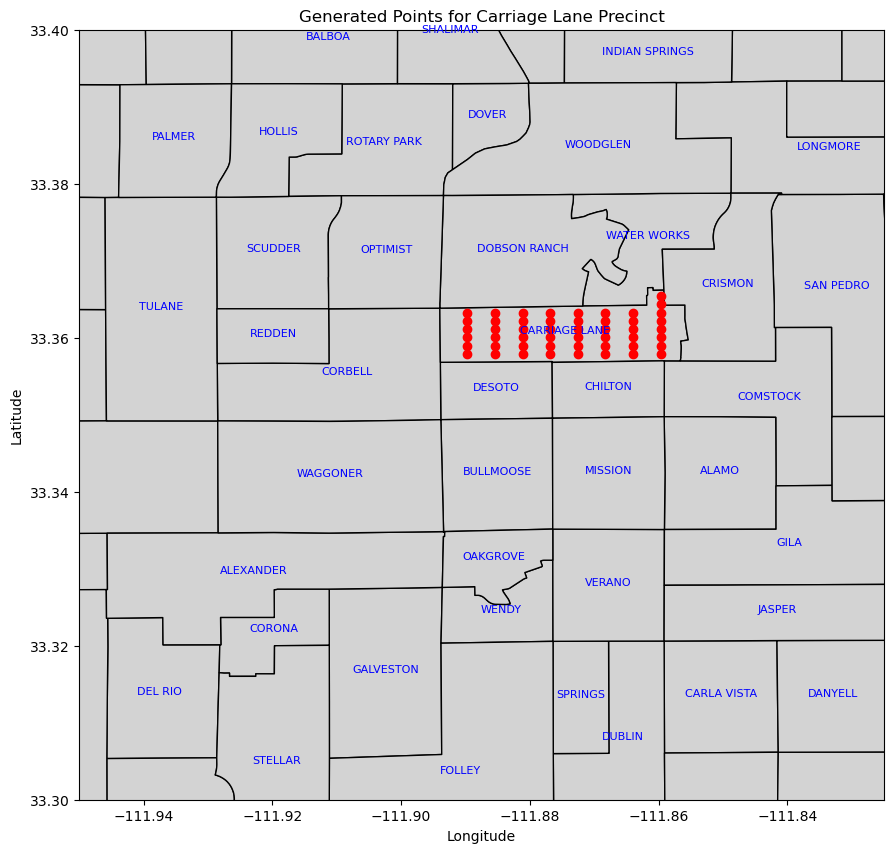

In [162]:
# Create an empty MultiPoint object to store all the points
all_points = MultiPoint()

# Iterate over the points in the dictionary and add them to the MultiPoint
for precinct, precinct_points in gen_points_dict.items():
    if precinct == 'CARRIAGE LANE':  # targeting 1 specific precinct for demonstrative purposes only
        all_points = all_points.union(MultiPoint([Point(coord) for coord in precinct_points]))

# Plot GeoDataFrame
ax = precincts_20.plot(figsize=(12, 10), color='lightgray', edgecolor='black')

# Plot all points
for point in all_points.geoms:
    plt.scatter(point.x, point.y, color='red', label='All Points')

# Annotate precincts
for index, row in precincts_20.iterrows():
    plt.annotate(row['BdName'], (row.geometry.centroid.x, row.geometry.centroid.y),
                 color='blue', fontsize=8, ha='center')

# Set x and y axis limits
plt.xlim(-111.95, -111.825)  # Set your desired x-axis range
plt.ylim(33.3, 33.4)  # Set your desired y-axis range

# Set labels and show the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Generated Points for Carriage Lane Precinct')

# Show the plot
plt.show()


Next we "flatten" the list of dictionaries ("gen_points_dict") we created above and turn it back into its own dataframe. 

In [163]:
# Flatten the list of dictionaries and round the generated coordinates to 15 decimal places
list_of_coordinates = [
    {'Precinct': precinct, 'geometry': Point((point.x), (point.y))}
    for precinct, points_list in gen_points_dict.items()
    for point in points_list
]

# Create the GeoDataFrame
df_points_20 = gpd.GeoDataFrame(list_of_coordinates, geometry='geometry', crs="EPSG:4326")



In [164]:
#create the Election Year column
df_points_20['Election Year'] = 2020

In [165]:
#inspect the geodataframe
df_points_20.head(5)

,Precinct,geometry,Election Year
0,LONE MOUNTAIN,POINT (-111.97640 33.76700),2020
1,LONE MOUNTAIN,POINT (-111.97640 33.77347),2020
2,LONE MOUNTAIN,POINT (-111.97117 33.76700),2020
3,LONE MOUNTAIN,POINT (-111.97117 33.77347),2020
4,LONE MOUNTAIN,POINT (-111.97117 33.77995),2020


In [166]:
#check for nulls
df_points_20.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39406 entries, 0 to 39405
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Precinct       39406 non-null  object  
 1   geometry       39406 non-null  geometry
 2   Election Year  39406 non-null  int64   
dtypes: geometry(1), int64(1), object(1)
memory usage: 923.7+ KB


Below we create a function which serves to convert the election results for each geo-coordinate into a 0, 1, or 2. This is important for both the Machine Learning algorithm we use later and also the statistical proportions test. 

In [167]:
#create a classification column based on the votes columns
#"Republican" = 0, "Democratic" = 1, "Other" = 2
def determine_label(row):
    """
    Create a classification label based on the votes columns.

    Parameters:
    - row (pandas.Series): A row of a DataFrame containing columns 'Republican', 'Democratic', and 'Other',
                          representing vote counts for different political parties.

    Returns:
    - str: The classification label: '0' for Republican, '1' for Democratic, '2' for Other.

    This function compares the vote counts for Republican, Democratic, and Other parties in a given row.
    It assigns a classification label based on which party has the highest vote count.
    The label '0' represents Republican, '1' represents Democratic, and '2' represents Other.

    Example:
    >>> sample_row = pd.Series({'Republican': 150, 'Democratic': 200, 'Other': 50})
    >>> determine_label(sample_row)
    '1'
    """
    if row['Republican'] > row['Democratic'] and row['Republican'] > row['Other']:
        return '0'
    elif row['Democratic'] > row['Republican'] and row['Democratic'] > row['Other']:
        return '1'
    else:
        return '2'


<div class="alert alert-info"><h1>3. Merge geometric points with historical voting results</h1></div> <a class="anchor" id="chapter3"></a>

<div class="alert alert-success"><h3>2020</h3></div> <a class="anchor" id="section_3_1"></a>

In [168]:
#join the results dataframe to the points dataframe to make sure all the precinct names are found between the two
merged_df_20 = df_points_20.merge(results_df, on=['Precinct', 'Election Year'], how='left')

In [169]:
# Create the calculated column 'Vote_Label' by calling the function 'determine_label'
merged_df_20['2020 Election Result'] = merged_df_20.apply(determine_label, axis=1)

In [170]:
#rename columns for clarity and consistency
merged_df_20 = merged_df_20.rename(columns={"Democratic": "2020 Democratic", "Republican": "2020 Republican", "Other": "2020 Other", "Precinct": "2020 Precinct"})

In [171]:
#drop extra columns we don't need
merged_df_20 = merged_df_20.drop(['Election Year', 'Precinct Number'], axis='columns')

In [172]:
#inspect the dataframe
merged_df_20.head(5)

,2020 Precinct,geometry,2020 Democratic,2020 Other,2020 Republican,2020 Election Result
0,LONE MOUNTAIN,POINT (-111.97640 33.76700),2469.0,63.0,4154.0,0
1,LONE MOUNTAIN,POINT (-111.97640 33.77347),2469.0,63.0,4154.0,0
2,LONE MOUNTAIN,POINT (-111.97117 33.76700),2469.0,63.0,4154.0,0
3,LONE MOUNTAIN,POINT (-111.97117 33.77347),2469.0,63.0,4154.0,0
4,LONE MOUNTAIN,POINT (-111.97117 33.77995),2469.0,63.0,4154.0,0


In [173]:
#check for nulls to find mismatches
merged_df_20.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 39406 entries, 0 to 39405
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   2020 Precinct         39406 non-null  object  
 1   geometry              39406 non-null  geometry
 2   2020 Democratic       39162 non-null  float64 
 3   2020 Other            39162 non-null  float64 
 4   2020 Republican       39162 non-null  float64 
 5   2020 Election Result  39406 non-null  object  
dtypes: float64(3), geometry(1), object(2)
memory usage: 2.1+ MB


We can see above that some of our generated coordinates did not match to election results. Let's see why.

In [174]:
#create an array of unique precinct names
point_df_pct = df_points_20['Precinct'].unique()

#return any precincts from the GEOdataframe that do not match to the results dataframe
print('Missing from results dataframe:')
for precinct in point_df_pct:
    if precinct in list_of_precincts:
        continue
    else:
        print(precinct)
        
#return any precincts from the results dataframe that do not match to the GEOdataframe
print('')
print('Missing from GEOdataframe:')
for precinct in list_of_precincts:
    if precinct in point_df_pct:
        continue
    else:
        print(precinct)

Missing from results dataframe:
SOUTH MTN PARK SW
SOUTH MTN PARK NE
SOUTH MTN PARK SOUTH
SOUTH MTN PARK SE
SOUTH MTN PARK EAST

Missing from GEOdataframe:


The South Mtn precincts that are missing are unique to a mountain preserve within Maricopa county. This preserve does not have any voting residents, which is why there are no results returned in the above queries for the 2020 election. These coordinates should be dropped, as they provide no value to the prediction project. 

We don't need to drop them now, because later when we have our master dataframe with all years we will drop any columns with null values. 

### Now that we have our points defined, based on the 2020 active voting precincts, we determine what precincts they were in during prior elections (and how those precincts voted in those elections)

First we read in the prior year geoJSON files and format them

In [175]:
#store the file in a geo dataframe
precincts_16 = gpd.read_file('Maricopa County Precinct GeoJSON Files/Maricopa_County_Voting_Precincts_(2012-2017).geojson')
#store the file in a geo dataframe
precincts_08 = gpd.read_file('Maricopa County Precinct GeoJSON Files/Maricopa_County_Voting_Precincts_(2008-2011).geojson')

In [176]:
#create a copy of the 2016 file for 2012, the boundaries were the same these years
precincts_12 = precincts_16.copy()

In [177]:
#define the election years and create the custom column
precincts_16['Election Year'] = 2016
precincts_12['Election Year'] = 2012
precincts_08['Election Year'] = 2008

In [178]:
#join the 2020 generated points to the 2016 boundaries to see what 2016 precincts those coordinates were in 
pointdf20_16 = gpd.sjoin(df_points_20, precincts_16, how="left", predicate="within")

In [179]:
#check for any nulls, these would be mismatches (which there should not be any)
pointdf20_16.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 39406 entries, 0 to 39405
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Precinct               39406 non-null  object  
 1   geometry               39406 non-null  geometry
 2   Election Year_left     39406 non-null  int64   
 3   index_right            39406 non-null  int64   
 4   OBJECTID               39406 non-null  int64   
 5   BdVal                  39406 non-null  object  
 6   PctNum                 39406 non-null  float64 
 7   SupervisorDistrict     39406 non-null  int64   
 8   LegislativeDistrict    39406 non-null  int64   
 9   CongressionalDistrict  39406 non-null  int64   
 10  CollegeDistrict        39406 non-null  int64   
 11  JusticePrecinct        39406 non-null  int64   
 12  BdName                 39406 non-null  object  
 13  SHAPE_Length           39406 non-null  float64 
 14  SHAPE_Area             39406 n

In [180]:
pointdf20_16.head(5)

,Precinct,geometry,Election Year_left,index_right,OBJECTID,BdVal,PctNum,SupervisorDistrict,LegislativeDistrict,CongressionalDistrict,CollegeDistrict,JusticePrecinct,BdName,SHAPE_Length,SHAPE_Area,Election Year_right
0,LONE MOUNTAIN,POINT (-111.97640 33.76700),2020,83,84,0366,366.0,2,15,6,2,25,LONE MOUNTAIN,0.226559,0.001825,2016
1,LONE MOUNTAIN,POINT (-111.97640 33.77347),2020,83,84,0366,366.0,2,15,6,2,25,LONE MOUNTAIN,0.226559,0.001825,2016
2,LONE MOUNTAIN,POINT (-111.97117 33.76700),2020,83,84,0366,366.0,2,15,6,2,25,LONE MOUNTAIN,0.226559,0.001825,2016
3,LONE MOUNTAIN,POINT (-111.97117 33.77347),2020,83,84,0366,366.0,2,15,6,2,25,LONE MOUNTAIN,0.226559,0.001825,2016
4,LONE MOUNTAIN,POINT (-111.97117 33.77995),2020,83,84,0366,366.0,2,15,6,2,25,LONE MOUNTAIN,0.226559,0.001825,2016


In [181]:
#drop unneccessary columns
pointdf20_16.drop(['Precinct', 'index_right', 'OBJECTID', 'BdVal', 'PctNum', 'SupervisorDistrict', 'LegislativeDistrict', 'CongressionalDistrict', 'CollegeDistrict', 'JusticePrecinct', 'SHAPE_Length', 'SHAPE_Area', 'Election Year_left'], axis=1, inplace=True)

In [182]:
#rename columns for clarity
pointdf20_16.rename(columns={"BdName": "Precinct", "Election Year_right": "Election Year"}, inplace = True)

In [183]:
pointdf20_16.head(5)

,geometry,Precinct,Election Year
0,POINT (-111.97640 33.76700),LONE MOUNTAIN,2016
1,POINT (-111.97640 33.77347),LONE MOUNTAIN,2016
2,POINT (-111.97117 33.76700),LONE MOUNTAIN,2016
3,POINT (-111.97117 33.77347),LONE MOUNTAIN,2016
4,POINT (-111.97117 33.77995),LONE MOUNTAIN,2016


<div class="alert alert-success"><h3>2016</h3></div> <a class="anchor" id="section_3_2"></a>

First we will check to see if there are any precinct name mismatches

In [184]:
# Define a list of unique precincts where Election Year is 2020
list_of_precincts16 = results_df[results_df['Election Year'] == 2016]['Precinct'].unique()

#create an array of unique precinct names
point_df_16 = pointdf20_16['Precinct'].unique()

#return any precincts from the GEOdataframe that do not match to the results dataframe
print('Missing from results dataframe:')
for precinct in point_df_16:
    if precinct in list_of_precincts16:
        continue
    else:
        print(precinct)
        
#return any precincts from the results dataframe that do not match to the GEOdataframe
print('')
print('Missing from GEOdataframe:')
for precinct in list_of_precincts16:
    if precinct in point_df_16:
        continue
    else:
        print(precinct)

Missing from results dataframe:
TOWNE MEADOWS

Missing from GEOdataframe:
TOWN MEADOWS


As you can see above, there is a mismatch in the 2016 data due to how "Town(e)" is spelled between the results dataframe and the GeoDataframe. I will format 1 to match the other.

In [185]:
# Replace 'TOWNE MEADOWS' with 'TOWN MEADOWS' in Precinct column
results_df['Precinct'].replace('TOWN MEADOWS', 'TOWNE MEADOWS', inplace = True)

In [186]:
#re-run the precinct name check

# Define a list of unique precincts where Election Year is 2020
list_of_precincts16 = results_df[results_df['Election Year'] == 2016]['Precinct'].unique()

#create an array of unique precinct names
point_df_16 = pointdf20_16['Precinct'].unique()

#return any precincts from the GEOdataframe that do not match to the results dataframe
print('Missing from results dataframe:')
for precinct in point_df_16:
    if precinct in list_of_precincts16:
        continue
    else:
        print(precinct)
        
#return any precincts from the results dataframe that do not match to the GEOdataframe
print('')
print('Missing from GEOdataframe:')
for precinct in list_of_precincts16:
    if precinct in point_df_16:
        continue
    else:
        print(precinct)

Missing from results dataframe:

Missing from GEOdataframe:


Now we see that we have no mismatches remaining for the 2016 election. 

In [187]:
#merge the results data with the coordinate data
merged_df_16 = pointdf20_16.merge(results_df, on=['Precinct', 'Election Year'], how='left')

In [188]:
# Create the calculated column 
merged_df_16['2016 Election Result'] = merged_df_16.apply(determine_label, axis=1)

In [189]:
#rename columns for consistency and clarity
merged_df_16 = merged_df_16.rename(columns={"Democratic": "2016 Democratic", "Republican": "2016 Republican", "Other": "2016 Other"})

In [190]:
#drop columns we don't need
merged_df_16 = merged_df_16.drop(['Precinct', 'Election Year', 'Precinct Number'], axis='columns')

In [191]:
#check for nulls to find mismatches
merged_df_16.head(5)

,geometry,2016 Democratic,2016 Other,2016 Republican,2016 Election Result
0,POINT (-111.97640 33.76700),1549,242,3085,0
1,POINT (-111.97640 33.77347),1549,242,3085,0
2,POINT (-111.97117 33.76700),1549,242,3085,0
3,POINT (-111.97117 33.77347),1549,242,3085,0
4,POINT (-111.97117 33.77995),1549,242,3085,0


<div class="alert alert-success"><h3>2012</h3></div> <a class="anchor" id="section_3_3"></a>

In [192]:
#join 2020 generated points to 2012 voting precinct boundaries to determine 2012 precincts for each coordinate
pointdf20_12 = gpd.sjoin(df_points_20, precincts_12, how="left", predicate="within")

In [193]:
#check for nulls (mismatches)
pointdf20_12.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 39406 entries, 0 to 39405
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Precinct               39406 non-null  object  
 1   geometry               39406 non-null  geometry
 2   Election Year_left     39406 non-null  int64   
 3   index_right            39406 non-null  int64   
 4   OBJECTID               39406 non-null  int64   
 5   BdVal                  39406 non-null  object  
 6   PctNum                 39406 non-null  float64 
 7   SupervisorDistrict     39406 non-null  int64   
 8   LegislativeDistrict    39406 non-null  int64   
 9   CongressionalDistrict  39406 non-null  int64   
 10  CollegeDistrict        39406 non-null  int64   
 11  JusticePrecinct        39406 non-null  int64   
 12  BdName                 39406 non-null  object  
 13  SHAPE_Length           39406 non-null  float64 
 14  SHAPE_Area             39406 n

In [194]:
#drop unneccessary columns
pointdf20_12.drop(['Precinct', 'index_right', 'OBJECTID', 'BdVal', 'PctNum', 'SupervisorDistrict', 'LegislativeDistrict', 'CongressionalDistrict', 'CollegeDistrict', 'JusticePrecinct', 'SHAPE_Length', 'SHAPE_Area', 'Election Year_left'], axis=1, inplace=True)

In [195]:
#rename columns for clarity
pointdf20_12.rename(columns={"BdName": "Precinct", "Election Year_right": "Election Year"}, inplace = True)

In [196]:
pointdf20_12.head(5)

,geometry,Precinct,Election Year
0,POINT (-111.97640 33.76700),LONE MOUNTAIN,2012
1,POINT (-111.97640 33.77347),LONE MOUNTAIN,2012
2,POINT (-111.97117 33.76700),LONE MOUNTAIN,2012
3,POINT (-111.97117 33.77347),LONE MOUNTAIN,2012
4,POINT (-111.97117 33.77995),LONE MOUNTAIN,2012


In [197]:
# Define a list of unique precincts where Election Year is 2012
list_of_precincts12 = results_df[results_df['Election Year'] == 2012]['Precinct'].unique()

#create an array of unique precinct names
point_df_12 = pointdf20_12['Precinct'].unique()

#return any precincts from the GEOdataframe that do not match to the results dataframe
print('Missing from results dataframe:')
for precinct in point_df_12:
    if precinct in list_of_precincts12:
        continue
    else:
        print(precinct)
        
#return any precincts from the results dataframe that do not match to the GEOdataframe
print('')
print('Missing from GEOdataframe:')
for precinct in list_of_precincts12:
    if precinct in point_df_12:
        continue
    else:
        print(precinct)

Missing from results dataframe:
MESQUITE
SUNLAND VILLAGE
PEBBLE CREEK

Missing from GEOdataframe:
CORTESSA
SUPERSTITION
TUSCANY FALLS


Mesquite and Cortessa mismatches are interesting, as when referencing the Maricopa County Recorder's Interactive Elections Map, it looks like Cortessa was the name of a pre-2012 redistricting precinct that was absorbed into 2 post-2012 redistricting precincts (Waddell and Mesquite.) This seems to be an actual error on the results file. But because of the split, I'm would have to reference the 2008 boundaries for this single 2012 precinct, which would add quite a bit of code to this file. As we will see later, I am going to opt to instead drop this mismatch altogether as it is not statistically relavent. 

The situation between Sunland Village/Superstition and Pebble Creek/Tuscany Falls is a little different, because while Superstition and Tuscany Falls are both pre-2012 redistricting precincts (as was Cortessa) the boundaries of these precincts were wholely absorbed into new precincts (Sunland Village and Pebble Creek, respectively.) This means we can simply rename the result_df precinct names to match the GeoDataFrame names. 


In [198]:
# Replace precinct names
results_df['Precinct'].replace('SUPERSTITION', 'SUNLAND VILLAGE', inplace = True)
results_df['Precinct'].replace('TUSCANY FALLS', 'PEBBLE CREEK', inplace = True)

In [199]:
# Define a list of unique precincts where Election Year is 2012
list_of_precincts12 = results_df[results_df['Election Year'] == 2012]['Precinct'].unique()

#create an array of unique precinct names
point_df_12 = pointdf20_12['Precinct'].unique()

#return any precincts from the GEOdataframe that do not match to the results dataframe
print('Missing from results dataframe:')
for precinct in point_df_12:
    if precinct in list_of_precincts12:
        continue
    else:
        print(precinct)
        
#return any precincts from the results dataframe that do not match to the GEOdataframe
print('')
print('Missing from GEOdataframe:')
for precinct in list_of_precincts12:
    if precinct in point_df_12:
        continue
    else:
        print(precinct)

Missing from results dataframe:
MESQUITE

Missing from GEOdataframe:
CORTESSA


In [200]:
#merge the results data with the coordinate data
merged_df_12 = pointdf20_12.merge(results_df, on=['Precinct', 'Election Year'], how='left')

In [201]:
# Create the calculated column 
merged_df_12['2012 Election Result'] = merged_df_12.apply(determine_label, axis=1)

In [202]:
merged_df_12 = merged_df_12.rename(columns={"Democratic": "2012 Democratic", "Republican": "2012 Republican", "Other": "2012 Other"})

In [203]:
merged_df_12 = merged_df_12.drop(['Precinct', 'Election Year', 'Precinct Number'], axis='columns')

In [204]:
#check for nulls to find mismatches
merged_df_12.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 39406 entries, 0 to 39405
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              39406 non-null  geometry
 1   2012 Democratic       39345 non-null  float64 
 2   2012 Other            39345 non-null  float64 
 3   2012 Republican       39345 non-null  float64 
 4   2012 Election Result  39406 non-null  object  
dtypes: float64(3), geometry(1), object(1)
memory usage: 1.8+ MB


<div class="alert alert-success"><h3>2008</h3></div> <a class="anchor" id="section_3_4"></a>

In [205]:
#join 2020 generated points to 2008 voting precinct boundaries to determine 2008 precincts for each coordinate
pointdf20_08 = gpd.sjoin(df_points_20, precincts_08, how="left", predicate="within")

In [206]:
#check for nulls (mismatches)
pointdf20_08.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 39406 entries, 0 to 39405
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Precinct               39406 non-null  object  
 1   geometry               39406 non-null  geometry
 2   Election Year_left     39406 non-null  int64   
 3   index_right            39406 non-null  int64   
 4   OBJECTID               39406 non-null  int64   
 5   BdVal                  39406 non-null  object  
 6   PctNum                 39406 non-null  float64 
 7   SupervisorDistrict     39406 non-null  int64   
 8   LegislativeDistrict    39406 non-null  int64   
 9   CongressionalDistrict  39406 non-null  int64   
 10  CollegeDistrict        39406 non-null  int64   
 11  JusticePrecinct        39406 non-null  int64   
 12  BdName                 39406 non-null  object  
 13  SHAPE_Length           39406 non-null  float64 
 14  SHAPE_Area             39406 n

In [207]:
#drop unneccessary columns
pointdf20_08.drop(['Precinct', 'index_right', 'OBJECTID', 'BdVal', 'PctNum', 'SupervisorDistrict', 'LegislativeDistrict', 'CongressionalDistrict', 'CollegeDistrict', 'JusticePrecinct', 'SHAPE_Length', 'SHAPE_Area', 'Election Year_left'], axis=1, inplace=True)

In [208]:
#rename columns for clarity
pointdf20_08.rename(columns={"BdName": "Precinct", "Election Year_right": "Election Year"}, inplace = True)

In [209]:
pointdf20_08.head(5)

,geometry,Precinct,Election Year
0,POINT (-111.97640 33.76700),WILDCAT,2008
1,POINT (-111.97640 33.77347),LONE MOUNTAIN,2008
2,POINT (-111.97117 33.76700),WILDCAT,2008
3,POINT (-111.97117 33.77347),LONE MOUNTAIN,2008
4,POINT (-111.97117 33.77995),LONE MOUNTAIN,2008


In [210]:
# Define a list of unique precincts where Election Year is 2012
list_of_precincts08 = results_df[results_df['Election Year'] == 2008]['Precinct'].unique()

#create an array of unique precinct names
point_df_08 = pointdf20_08['Precinct'].unique()

#return any precincts from the GEOdataframe that do not match to the results dataframe
print('Missing from results dataframe:')
for precinct in point_df_08:
    if precinct in list_of_precincts08:
        continue
    else:
        print(precinct)
        
#return any precincts from the results dataframe that do not match to the GEOdataframe
print('')
print('Missing from GEOdataframe:')
for precinct in list_of_precincts08:
    if precinct in point_df_08:
        continue
    else:
        print(precinct)

Missing from results dataframe:
SUPERSTITION
TUSCANY FALLS

Missing from GEOdataframe:
MULBERRY
SUNLAND VILLAGE
PEBBLE CREEK


Some of the mismatches above are from our fix in the 2012 election, so we will reverse that for the 2008 merge. 

In [211]:
results_df['Precinct'].replace('SUNLAND VILLAGE', 'SUPERSTITION', inplace = True)
results_df['Precinct'].replace('PEBBLE CREEK', 'TUSCANY FALLS', inplace = True)

In [212]:
# Define a list of unique precincts where Election Year is 2012
list_of_precincts08 = results_df[results_df['Election Year'] == 2008]['Precinct'].unique()

#create an array of unique precinct names
point_df_08 = pointdf20_08['Precinct'].unique()

#return any precincts from the GEOdataframe that do not match to the results dataframe
print('Missing from results dataframe:')
for precinct in point_df_08:
    if precinct in list_of_precincts08:
        continue
    else:
        print(precinct)
        
#return any precincts from the results dataframe that do not match to the GEOdataframe
print('')
print('Missing from GEOdataframe:')
for precinct in list_of_precincts08:
    if precinct in point_df_08:
        continue
    else:
        print(precinct)

Missing from results dataframe:

Missing from GEOdataframe:
MULBERRY


I was unable to verify where Mulberry precinct was located. However, it represents only a few of the geometric points in our dataset. So, I will drop it when I drop the N/As later on. 

In [213]:
#merge the results data with the coordinate data
merged_df_08 = pointdf20_08.merge(results_df, on=['Precinct', 'Election Year'], how='left')

In [214]:
# Create the calculated column 
merged_df_08['2008 Election Result'] = merged_df_08.apply(determine_label, axis=1)

In [215]:
merged_df_08 = merged_df_08.rename(columns={"Democratic": "2008 Democratic", "Republican": "2008 Republican", "Other": "2008 Other"})

In [216]:
merged_df_08 = merged_df_08.drop(['Precinct', 'Election Year', 'Precinct Number'], axis='columns')

In [217]:
#check for nulls to find mismatches
merged_df_08.head(5)

,geometry,2008 Democratic,2008 Other,2008 Republican,2008 Election Result
0,POINT (-111.97640 33.76700),687,36,1509,0
1,POINT (-111.97640 33.77347),315,11,617,0
2,POINT (-111.97117 33.76700),687,36,1509,0
3,POINT (-111.97117 33.77347),315,11,617,0
4,POINT (-111.97117 33.77995),315,11,617,0


<div class="alert alert-success"><h3>Create the master file</h3></div> <a class="anchor" id="section_3_5"></a>

In [218]:
#merge all of the merged dataframes together 
master_df1 = merged_df_20.merge(merged_df_16, on=['geometry'], how='outer')
master_df2 = master_df1.merge(merged_df_12, on=['geometry'], how='outer')
master_df = master_df2.merge(merged_df_08, on=['geometry'], how='outer')

As noted above, we did find some mismatches between the shapefiles and the results data. Let's take a look at how many of our points are mismatched. 

In [219]:
#check for nulls
master_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 39406 entries, 0 to 39405
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   2020 Precinct         39406 non-null  object  
 1   geometry              39406 non-null  geometry
 2   2020 Democratic       39162 non-null  float64 
 3   2020 Other            39162 non-null  float64 
 4   2020 Republican       39162 non-null  float64 
 5   2020 Election Result  39406 non-null  object  
 6   2016 Democratic       39406 non-null  int64   
 7   2016 Other            39406 non-null  int64   
 8   2016 Republican       39406 non-null  int64   
 9   2016 Election Result  39406 non-null  object  
 10  2012 Democratic       39345 non-null  float64 
 11  2012 Other            39345 non-null  float64 
 12  2012 Republican       39345 non-null  float64 
 13  2012 Election Result  39406 non-null  object  
 14  2008 Democratic       39406 non-null  int64   

So, we start with a total of 39,406 generated points within the county. 

In [220]:
#drop the nulls
master_df = master_df.dropna()

In [221]:
#check for nulls
master_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 39101 entries, 0 to 39405
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   2020 Precinct         39101 non-null  object  
 1   geometry              39101 non-null  geometry
 2   2020 Democratic       39101 non-null  float64 
 3   2020 Other            39101 non-null  float64 
 4   2020 Republican       39101 non-null  float64 
 5   2020 Election Result  39101 non-null  object  
 6   2016 Democratic       39101 non-null  int64   
 7   2016 Other            39101 non-null  int64   
 8   2016 Republican       39101 non-null  int64   
 9   2016 Election Result  39101 non-null  object  
 10  2012 Democratic       39101 non-null  float64 
 11  2012 Other            39101 non-null  float64 
 12  2012 Republican       39101 non-null  float64 
 13  2012 Election Result  39101 non-null  object  
 14  2008 Democratic       39101 non-null  int64   

After dropping the nulls, we find that we have 39,101 points remaining. Meaning we lost 0.77% of our data. This is not statistically significant, so we will stick with simply dropping the mismatches, as we did above. 

Next, we want to see how much of our data had a result of "Other", meaning these points voted more for 3rd-party candidates than Republican or Democratic candidates. We want to preserve a binary stucture for our machine learning model, meaning we only want observations with a result of "Republican" or "Democratic." 

In [222]:
# Define the election years
election_years = ['2020', '2016', '2012', '2008']

# Create a filter for rows where "2" is NOT the result for any election year
filter_not_other = ~master_df[[f'{year} Election Result' for year in election_years]].eq('2').any(axis=1)

# Apply the filter to the GeoDataFrame
master_df = master_df[filter_not_other]

In [223]:
#check to see how many rows we dropped
master_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 38894 entries, 0 to 39405
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   2020 Precinct         38894 non-null  object  
 1   geometry              38894 non-null  geometry
 2   2020 Democratic       38894 non-null  float64 
 3   2020 Other            38894 non-null  float64 
 4   2020 Republican       38894 non-null  float64 
 5   2020 Election Result  38894 non-null  object  
 6   2016 Democratic       38894 non-null  int64   
 7   2016 Other            38894 non-null  int64   
 8   2016 Republican       38894 non-null  int64   
 9   2016 Election Result  38894 non-null  object  
 10  2012 Democratic       38894 non-null  float64 
 11  2012 Other            38894 non-null  float64 
 12  2012 Republican       38894 non-null  float64 
 13  2012 Election Result  38894 non-null  object  
 14  2008 Democratic       38894 non-null  int64   

By dropping the points that voted for 3rd party candidates, we are now at a total of 38,897 rows. Meaning we dropped 207 rows or 0.53% of our data. This is not statistically significant, so we will continue on. 

Finally, we want to split the latitude and longitude as two distinct columns so that both can be used as distinct features in the Logistic Regression model.

In [224]:
# Extract latitude and longitude from the geometry column
master_df['Latitude'] = master_df['geometry'].y
master_df['Longitude'] = master_df['geometry'].x

In [225]:
master_df.head(5)

,2020 Precinct,geometry,2020 Democratic,2020 Other,2020 Republican,2020 Election Result,2016 Democratic,2016 Other,2016 Republican,2016 Election Result,2012 Democratic,2012 Other,2012 Republican,2012 Election Result,2008 Democratic,2008 Other,2008 Republican,2008 Election Result,Latitude,Longitude
0,LONE MOUNTAIN,POINT (-111.97640 33.76700),2469.0,63.0,4154.0,0,1549,242,3085,0,961.0,60.0,2542.0,0,687,36,1509,0,33.767002,-111.976401
1,LONE MOUNTAIN,POINT (-111.97640 33.77347),2469.0,63.0,4154.0,0,1549,242,3085,0,961.0,60.0,2542.0,0,315,11,617,0,33.773475,-111.976401
2,LONE MOUNTAIN,POINT (-111.97117 33.76700),2469.0,63.0,4154.0,0,1549,242,3085,0,961.0,60.0,2542.0,0,687,36,1509,0,33.767002,-111.971173
3,LONE MOUNTAIN,POINT (-111.97117 33.77347),2469.0,63.0,4154.0,0,1549,242,3085,0,961.0,60.0,2542.0,0,315,11,617,0,33.773475,-111.971173
4,LONE MOUNTAIN,POINT (-111.97117 33.77995),2469.0,63.0,4154.0,0,1549,242,3085,0,961.0,60.0,2542.0,0,315,11,617,0,33.779947,-111.971173


<div class="alert alert-info"><h2>4. Train and Test a Logistic Regression Model</h2></div> <a class="anchor" id="chapter4"></a>

<div class="alert alert-success"><h3>Linearity check</h3></div> <a class="anchor" id="section_4_1"></a> 

Now that we have our master dataframe with all our generated coordinates matching to election results, we need to verify if the historical results are roughly linear to each other. Logistic Regression is sensitive to linearity, so this step is important in testing if our select of ML model is a good one.

In [226]:
# Calculate the correlation coefficient
correlation_coefficient, _ = pearsonr(master_df['2016 Republican'], master_df['2020 Republican'])

print(f"2020 to 2016 Correlation Coefficient: {correlation_coefficient}")

2020 to 2016 Correlation Coefficient: 0.8116870617438469


In [227]:
correlation_coefficient, _ = pearsonr(master_df['2012 Republican'], master_df['2016 Republican'])

print(f"2016 to 2012 Correlation Coefficient: {correlation_coefficient}")

2016 to 2012 Correlation Coefficient: 0.966669449579725


In [228]:
correlation_coefficient, _ = pearsonr(master_df['2008 Republican'], master_df['2012 Republican'])

print(f"2012 to 2008 Correlation Coefficient: {correlation_coefficient}")

2012 to 2008 Correlation Coefficient: 0.6732734366249681


Even though the 2008-to-2020 coefficient is lighter than the other years, all 3 comparisons show strong linearity, which supports our choice in Logistic Regression. 

<div class="alert alert-success"><h3>Train and test model</h3></div> <a class="anchor" id="section_4_3"></a> 

There next part is important: We have to split our dataframe between the 2020 election results and the non-2020 election results, since the 2020 results are what we are predicting. We do not want the AI model to be trained on the actual results that it will be predicting...that's cheating ;)

In [229]:
# Separate the data into training (elections other than 2020) and testing (2020 election)
gdf_train = master_df.drop(['2020 Election Result', '2020 Democratic', '2020 Republican', '2020 Other'], axis='columns')
gdf_train.rename(columns={"2016 Election Result": "Current Year Result","2016 Democratic": "Current Year Democratic", "2016 Republican": "Current Year Republican", "2016 Other": "Current Year Other", "2012 Election Result": "Prior Year Result", "2012 Democratic": "Prior Year Democratic", "2012 Republican": "Prior Year Republican", "2012 Other": "Prior Year Other", "2008 Election Result": "2 Prior Year Result", "2008 Democratic": "2 Prior Year Democratic", "2008 Republican": "2 Prior Year Republican", "2008 Other": "2 Prior Year Other"}, inplace=True)

gdf_test = master_df.drop(['2008 Election Result', '2008 Democratic', '2008 Republican', '2008 Other'], axis='columns')
gdf_test.rename(columns={"2020 Election Result": "Current Year Result","2020 Democratic": "Current Year Democratic", "2020 Republican": "Current Year Republican", "2020 Other": "Current Year Other", "2016 Election Result": "Prior Year Result", "2016 Democratic": "Prior Year Democratic", "2016 Republican": "Prior Year Republican", "2016 Other": "Prior Year Other", "2012 Election Result": "2 Prior Year Result", "2012 Democratic": "2 Prior Year Democratic", "2012 Republican": "2 Prior Year Republican", "2012 Other": "2 Prior Year Other"}, inplace=True)

In [230]:
# here we define the 'features' (the elements we want to use to predict) and the 'target' (the prediction variable)
features = ['Latitude', 'Longitude', 'Prior Year Result', '2 Prior Year Result']
target = 'Current Year Result'


In [231]:
# define the X and the Y for the train and test data
X_train, y_train = gdf_train[features], gdf_train[target]
X_test, y_test = gdf_test[features], gdf_test[target]

In [232]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [233]:
# Model Training
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [234]:
# Model Evaluation
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))

Accuracy: 0.91016609245642

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91     18217
           1       0.99      0.84      0.91     20677

    accuracy                           0.91     38894
   macro avg       0.92      0.91      0.91     38894
weighted avg       0.92      0.91      0.91     38894



<div class="alert alert-success"><h3>Check results</h3></div> <a class="anchor" id="section_4_4"></a> 

Now, let's break down the results:

1. **Accuracy: 0.91**
   - This represents the overall correctness of the model. An accuracy of 0.91 means that the model correctly predicted the 2020 election result for approximately 91% of the data points in our test set.

2. **Classification Report:**

   - **Precision:** Precision is the ratio of correctly predicted positive observations to the total predicted positives. In our case:
     - Precision for class '0': 0.84 (84% of instances predicted as '0' were actually '0').
     - Precision for class '1': 0.96 (96% of instances predicted as '1' were actually '1').
     
   - **Recall:** Recall is the ratio of correctly predicted positive observations to the all observations in the actual class. In your case:
     - Recall for class '0': 0.99 (99% of actual '0' instances were correctly predicted as '0').
     - Recall for class '1': 0.84 (84% of actual '1' instances were correctly predicted as '1').
     
   - **F1-score:** F1-score is the weighted average of precision and recall. It balances precision and recall. In your case:
     - F1-score for class '0': 0.91 (a good balance between precision and recall).
     - F1-score for class '1': 0.91 (a good balance between precision and recall).

3. **Macro Avg and Weighted Avg:**

   - **Macro Avg:** It calculates the average of metrics for each class without considering class imbalance. In our case, the macro average F1-score is 0.91.
   
   - **Weighted Avg:** It considers the number of samples for each class. In our case, the weighted average F1-score is 0.91, which indicates a good overall performance.
   

4. **Analysis:**
   - The model performs well for classes '0'(Republican) and '1'(Democrat), with high precision and recall. 

Overall, our model performs extremely well in predicting the 2020 election results.

<div class="alert alert-info"><h2>5. Create Random Guesses to Compare</h2></div> <a class="anchor" id="chapter5"></a>

Now we need to see how well out model did compared to random chance. To do this, we will need to format the predicted and actual 2020 results as numeric values. This will enable us to use statistical analysis to see the proportions of accurate predictions.

In [235]:
#create dataframe from the Logistic Regression results
results_df = pd.DataFrame({
    'Actual_Labels': y_test,
    'Predicted_Labels': y_pred,
    'Latitude': X_test['Latitude'],
    'Longitude': X_test['Longitude']
})

# Convert 'Actual_Labels' and 'Predicted_Labels' columns to numeric
results_df['Actual_Labels'] = pd.to_numeric(results_df['Actual_Labels'], errors='coerce')
results_df['Predicted_Labels'] = pd.to_numeric(results_df['Predicted_Labels'], errors='coerce')

# Check the data types of the columns
results_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38894 entries, 0 to 39405
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Actual_Labels     38894 non-null  int64  
 1   Predicted_Labels  38894 non-null  int64  
 2   Latitude          38894 non-null  float64
 3   Longitude         38894 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 1.5 MB


Below we use numpy's random seed function to generate random results for the 2020 election. 

In [236]:
# Set seed for reproducibility
np.random.seed(42)

# Number of rows in the DataFrame
num_rows = len(results_df)

# Generate random predictions (0 or 1) with equal probability
random_predictions = np.random.choice([0, 1], size=num_rows)

# Create a new column in the DataFrame for the random predictions
results_df['Random_Predictions'] = random_predictions


<div class="alert alert-info"><h2>6. Export CSV File of Results (deliverable 1)</h2></div> <a class="anchor" id="chapter6"></a>

In [237]:
#merge our results dataframe with the randomly generated results
export_df = results_df.merge(master_df, left_on=['Latitude', 'Longitude'], right_on=['Latitude', 'Longitude'], how='left')

# Export the results DataFrame to a CSV file
export_df.to_csv('results.csv', index=False)

<div class="alert alert-info"><h2>7. Statistical Analysis</h2></div> <a class="anchor" id="chapter7"></a>

<div class="alert alert-success"><h3>Hypothesis</h3></div> <a class="anchor" id="section_7_1"></a> 

Our null hypothesis for this analysis is that the proportion of accurate predictions is less than or equal to the proportion of accurate random results:

$$
H_0: \text{Pred_Acc} \leq \text{Rand_Acc} 
$$

Our alternative hypothesis for this analysis is that the proportion of accurate predictions is greater than the proportion of accurate random results:

$$ H_1: \text{Pred_Acc} > \text{Rand_Acc} 
$$



For this analysis, we will use a proportion z-test to compare the proportions of accurate predictions to accurate guesses. This test will provide us with a z-score and a p-value which will help us determine if our results are statistically significant.

<div class="alert alert-success"><h3>Proportions z-test</h3></div> <a class="anchor" id="section_7_2"></a> 

In [248]:
# Calculate accuracy for both Predicted_Labels and Random_Predictions
accuracy_predicted = (accuracy_score(results_df['Actual_Labels'], results_df['Predicted_Labels'])) *100
accuracy_random = (accuracy_score(results_df['Actual_Labels'], results_df['Random_Predictions'])) * 100

# Count correct predictions for both models
correct_predicted = (results_df['Actual_Labels'] == results_df['Predicted_Labels']).sum()
correct_random = (results_df['Actual_Labels'] == results_df['Random_Predictions']).sum()

# Number of observations
n_obs = len(results_df)

# Perform a z-test for proportions
z_score, p_value = proportions_ztest(count=[correct_predicted, correct_random], nobs=[n_obs, n_obs], prop_var=(accuracy_random/100), alternative='larger')

print(f"Z-Score: {z_score}")
print(f"P-Value: {p_value:.15f}")

print(f"Accuracy_predicted: {accuracy_predicted:.2f}")
print(f"Accuracy_random: {accuracy_random:.2f}")

print(f"Correctly Predicted Count: {correct_predicted}")
print(f"Correctly Guessed Count: {correct_random}")
print(f"Total Rows: {n_obs}")

Z-Score: 115.01519682565633
P-Value: 0.000000000000000
Accuracy_predicted: 91.02
Accuracy_random: 49.78
Correctly Predicted Count: 35400
Correctly Guessed Count: 19361
Total Rows: 38894


<div class="alert alert-success"><h3>Statistical Test Results</h3></div> <a class="anchor" id="section_7_3"></a> 

The <b>Z-Score</b> is a measure of how many standard deviations an element is from the mean. In this context, it reflects how many standard deviations the predicted accuracy is from the guessed accuracy under the null hypothesis.
- The high z-score  of 115.02 indicates that the observed difference in proportions is significantly larger than what would be expected by random chance alone. 

The <b>P-Value</b> is the probability of observing a Z-Score as extreme as the one calculated, assuming that the null hypothesis is true. In other words, it indicates the likelihood of obtaining the predicted accuracy or more extreme values if there is no actual difference between predicted and guessed results. 
- The extremely low p-value of 0.00 indicates that it is extremely unlikely that our results were generated by random chance

We already knew from the accuracy scores that our predictions were much closer to actual results than the random guesses, but the statistical analysis helps to solidify the significance of the performance of the prediction model. These results tell us that our predicted results were quite significantly different, and more accurate, than the random guesses. 

Given the above results, we have sufficient evidence to reject the null hypothesis.

<div class="alert alert-info"><h2>8. Investigate the Results</h2></div> <a class="anchor" id="chapter8"></a>

<div class="alert alert-success"><h3>Map plot of inaccurate results</h3></div> <a class="anchor" id="section_8_1"></a> 

Our model performs extremely well in predicting how each geometric point will vote, given historical results. But what about the areas it didn't predict? Do these points on the map give us any clues into either the model's performance or the political landscape within the county?

In [239]:
#isolate the incorrectly predicted points
incorrect_predicted = export_df[export_df['Actual_Labels'] != export_df['Predicted_Labels']]

In [240]:
#convert the dataframes to geodataframes
incorrect_geo = gpd.GeoDataFrame(
    incorrect_predicted, geometry=gpd.points_from_xy(incorrect_predicted.Longitude, incorrect_predicted.Latitude), crs="EPSG:4326"
)

all_geo = gpd.GeoDataFrame(
    export_df, geometry=gpd.points_from_xy(export_df.Longitude, export_df.Latitude), crs="EPSG:4326"
)

In [241]:
#our contextily map is defined in epsg 3857, so our GeoDataFrames should match this as well. 
df_in = incorrect_geo.to_crs(epsg=3857)
df_all = all_geo.to_crs(epsg=3857)

<Figure size 1000x800 with 0 Axes>

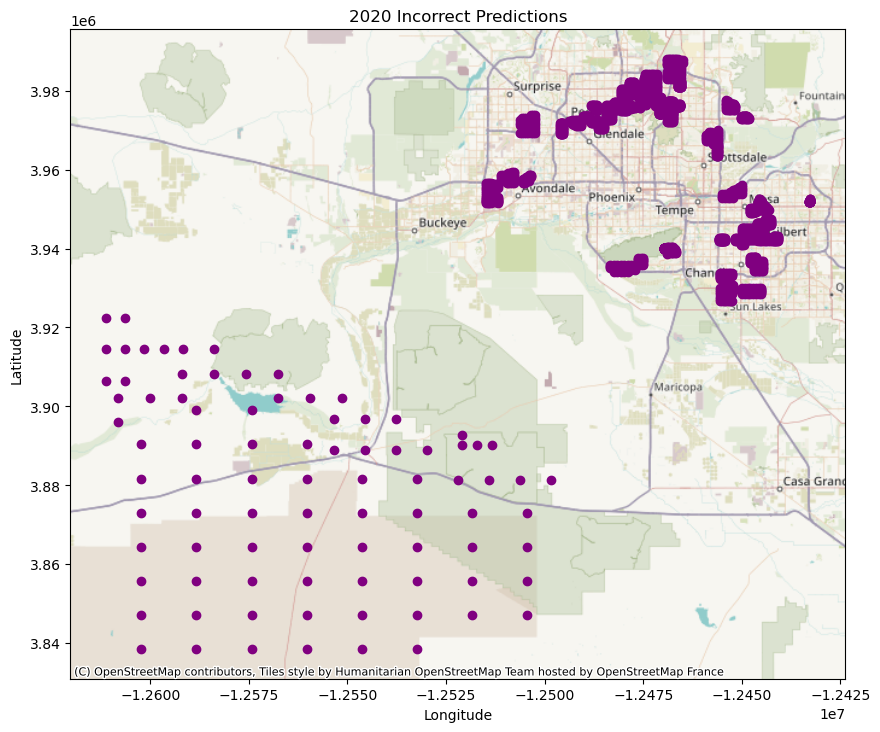

In [242]:
# Create a scatter plot for incorrect predictions
plt.figure(figsize=(10, 8))

# Plot GeoDataFrame
ax = df_in.plot(figsize=(10, 18), alpha = 1, color='purple')
cx.add_basemap(ax)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2020 Incorrect Predictions')

# Display the plot
plt.show()


These results are interesting, as the incorrect predictions are (mostly) on the edges of the urban center of the county with a notable exception in the lower quadrant of the county, which is a more rural and less populated area. 

Let's take a look at how these incorrectly predicted points have voted overtime. 

<div class="alert alert-success"><h3>Map plot of inaccurate results - historical elections</h3></div> <a class="anchor" id="section_8_2"></a> 

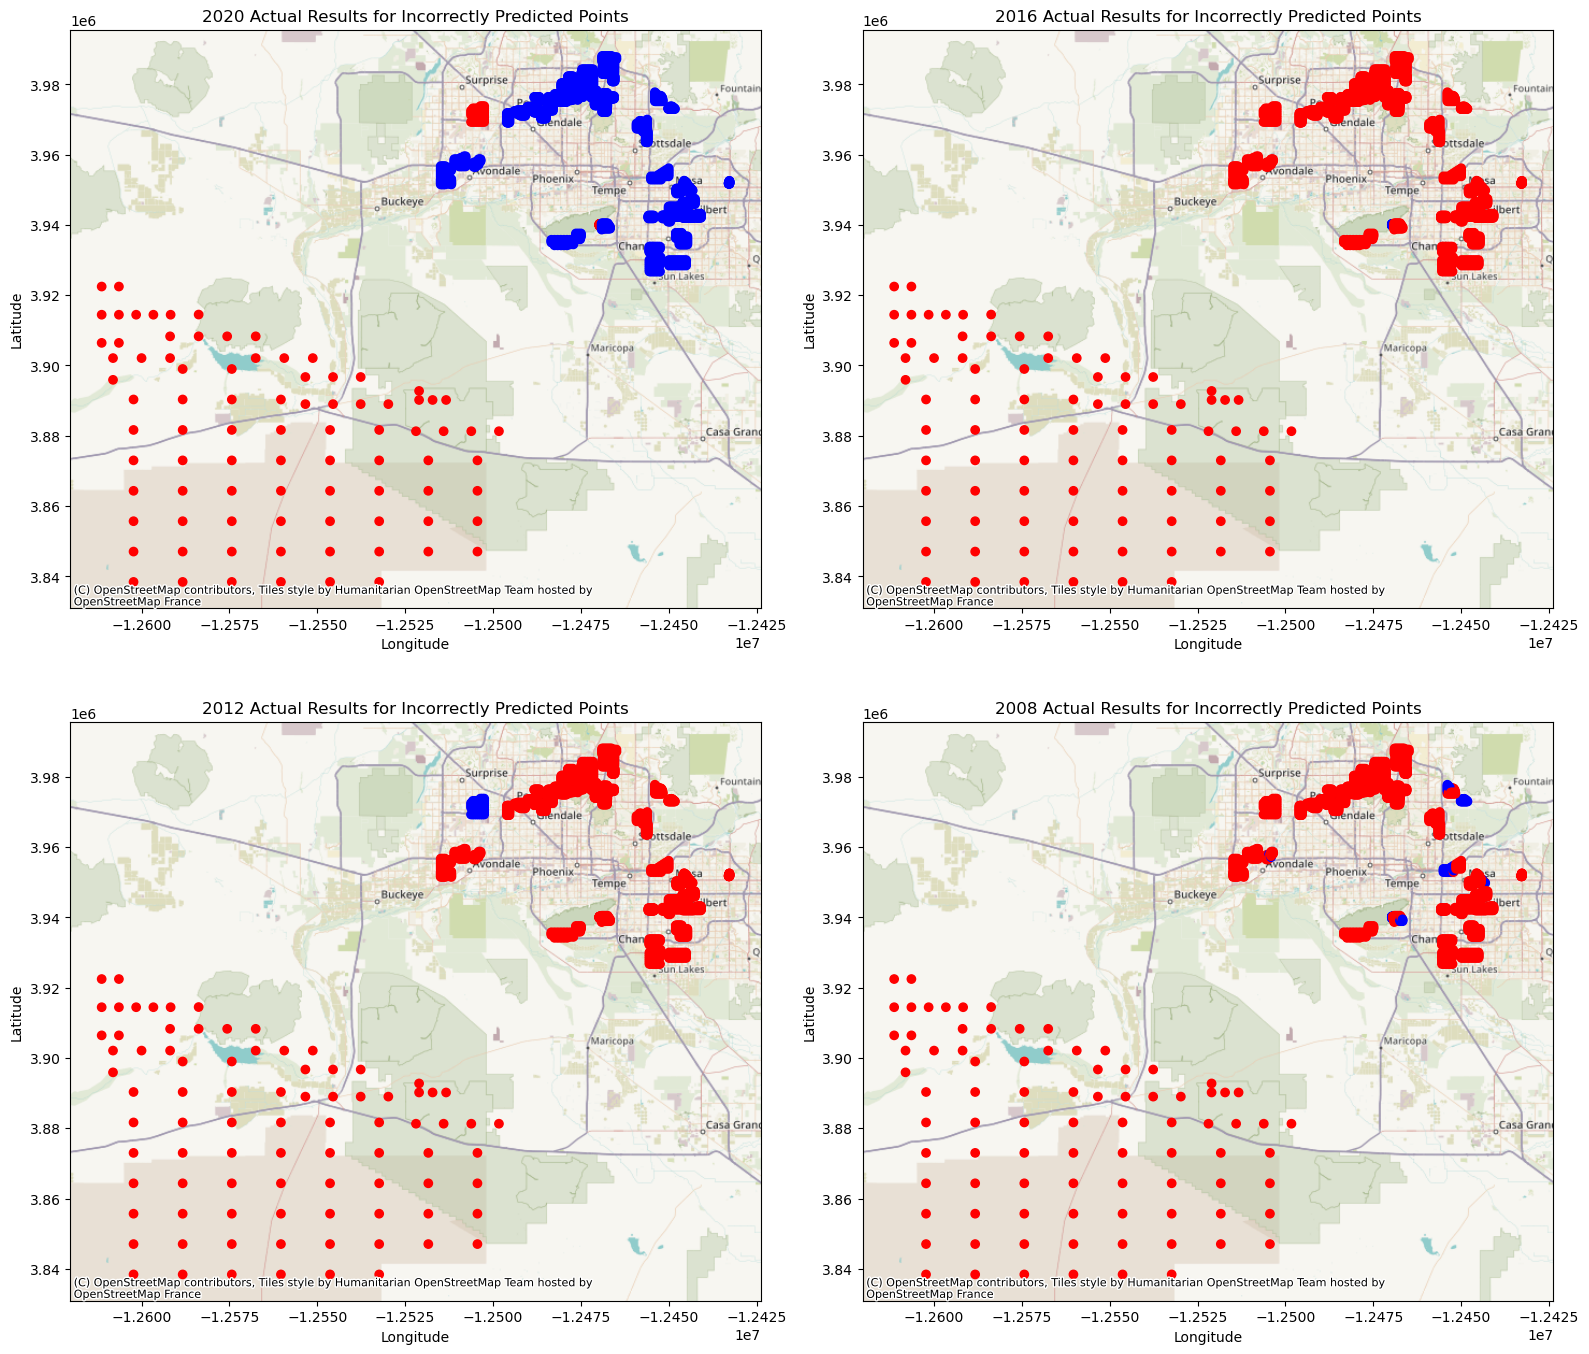

In [243]:
# Create a scatter plot for incorrect predictions 
plt.figure(figsize=(16, 14))

# Define the years
years = ['2020', '2016', '2012', '2008']

# Create subplots in a 2x2 grid
for i, year in enumerate(years, 1):
    plt.subplot(2, 2, i)

    # Plot GeoDataFrame for the specific year
    ax = df_in.plot(ax=plt.gca(), alpha=1, color=['red' if result == '0' else 'blue' if result == '1' else 'green' for result in df_in[f'{year} Election Result']])
    cx.add_basemap(ax)

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{year} Actual Results for Incorrectly Predicted Points')
    
    # Adjust figsize for subplots
    plt.gcf().set_size_inches(16, 14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

Here we can see a pretty drastic shift from Republican to Democrat votes in the areas the machine learning model incorrectly predicted. Indeed, this sudden shift seems greatly disproportionate to historical trends. However, let's provide some additional context to what might be going on in these areas by including all points - both correctly predicted and incorrectly predicted. 

<div class="alert alert-success"><h3>Map plot of inaccurate results - historical elections - urban center</h3></div> <a class="anchor" id="section_8_3"></a> 

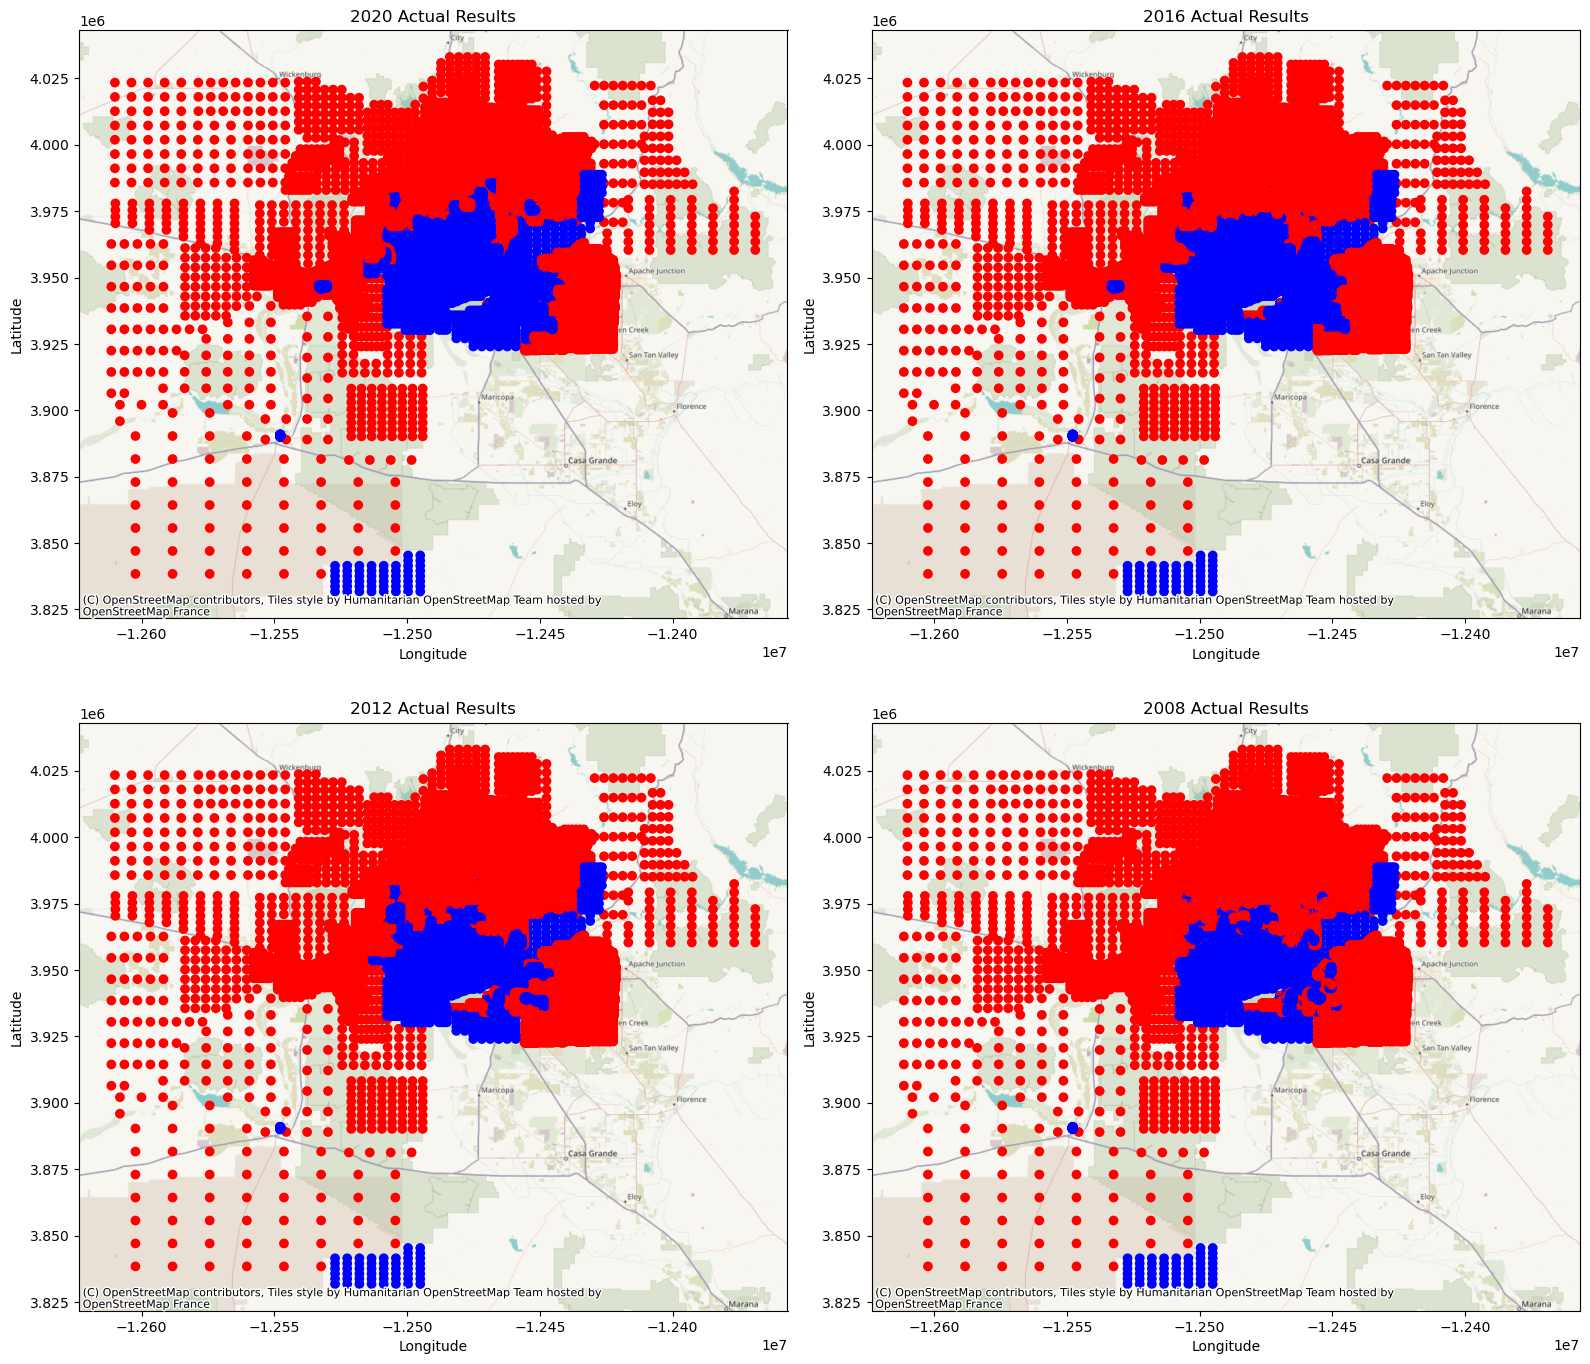

In [244]:
# Create a scatter plot for incorrect predictions 
plt.figure(figsize=(16, 14))

# Define the years
years = ['2020', '2016', '2012', '2008']

# Create subplots in a 2x2 grid
for i, year in enumerate(years, 1):
    plt.subplot(2, 2, i)

    # Plot GeoDataFrame for the specific year
    ax = df_all.plot(ax=plt.gca(), alpha=1, color=['red' if result == '0' else 'blue' if result == '1' else 'green' for result in df_all[f'{year} Election Result']])
    cx.add_basemap(ax)

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{year} Actual Results')
    
    # Adjust figsize for subplots
    plt.gcf().set_size_inches(16, 14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

The rural points in the lower left that voted consistantly red, yet which the model predicted would vote blue, seem heavily influenced by the more clustered points at the lower portion of the map (near -1.25 Longitude and 3.850 Latitude.) This effect could possibly be limited to increase the accuracy of the Logistic Regression model by adjusting various settings and weights when training the model. These incorrectly predicted points seem less influenced by political fluctuations and more of a result of a failure in the model itself. Finer tuning of the model could potentially be performed to mitigate such inaccurate results. 

But in the urban center we see a more gradual and steady spread of Democratic votes, out from the urban center of the county into the more surburban areas. This suggests to us that the model, when failing to predict the 2020 outcome in the points surrounding the urban center, is revealing areas of greater political fluctuation. 

To illustrate this further, below is an animated plot of the urban areas, which helps to show this gradual and steady change more clearly. 

<div class="alert alert-success"><h3>Animated map of all election results</h3></div> <a class="anchor" id="section_8_4"></a> 

<IPython.core.display.Javascript object>


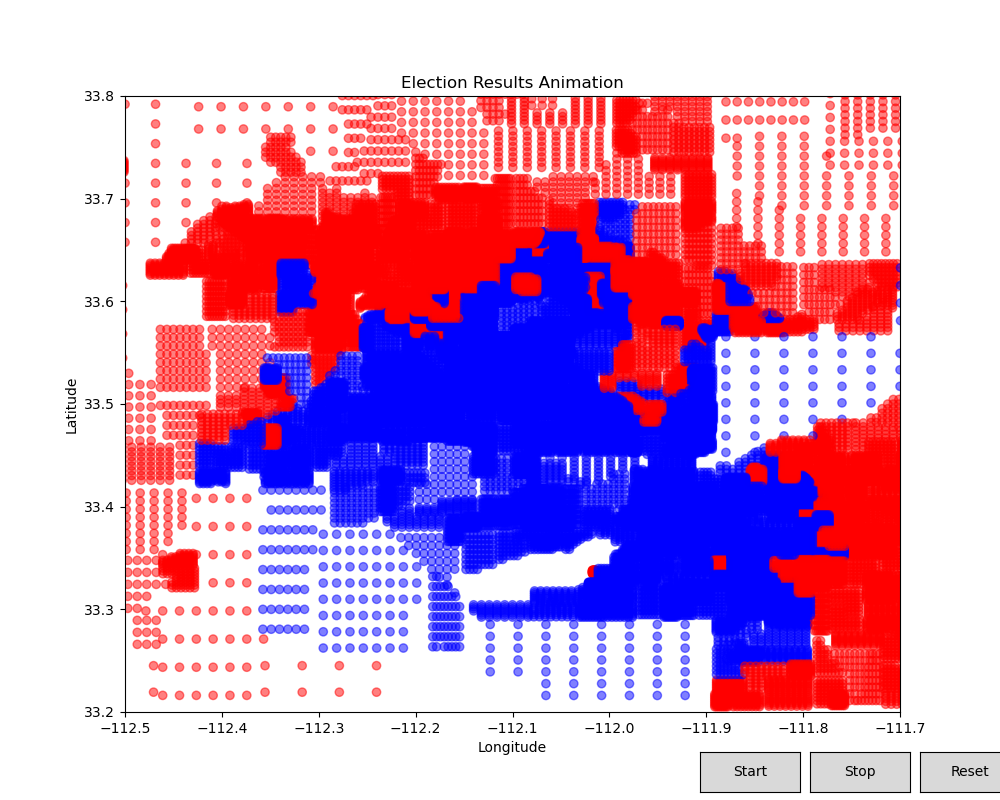

In [245]:
%matplotlib notebook
# Create a figure for plotting
fig, ax = plt.subplots(figsize=(10, 8))


# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Election Results Animation')

# Add a text annotation for displaying the election year
year_text = ax.text(0.95, 0.95, '', transform=ax.transAxes, ha='right', va='top', fontsize=22, weight = 'bold')

# Define a function to animate the plot
def animate(frame_num):
    """
    Animate the election results plot for different years.

    Parameters:
    - frame_num (int): The current frame number indicating the index of the year to be animated.

    Returns:
    - tuple: A tuple containing the scatter plot and the text annotation.

    This function is designed to be used as an animation function. It updates the scatter plot and text annotation
    for each frame, representing different election years. The colors of points on the plot correspond to election
    results ('0' for Republican, '1' for Democratic) for the current animated year.

    Example:
    >>> animate(2)
    (<matplotlib.collections.PathCollection object at 0x...>, Text(0.5, 1.0, '2016 Results'))
    """
    # Map the year to the corresponding column in the DataFrame
    years = ['2008', '2012', '2016', '2020']
    current_year = years[frame_num % len(years)]
    
    colors = ['red' if result == '0' else 'blue' for result in export_df[f'{current_year} Election Result']]
    
    # Clear the previous scatter plot
    ax.clear()
    
    # Add labels and title again
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Election Results Animation')
    
    # Set limits for X and Y axes
    ax.set_xlim(-112.5, -111.7)  
    ax.set_ylim(33.2, 33.8)  
    
    # Create a new scatter plot
    sc = ax.scatter(export_df['Longitude'], export_df['Latitude'], c=colors, marker='o', alpha=0.5)
    
    # Update the text annotation with the current election year
    year_text.set_text(f'{current_year} Results')
    
    return sc, year_text

# Set limits for X and Y axes
ax.set_xlim(-112.5, -111.7)  
ax.set_ylim(33.2, 33.8)  

# Define functions to start, stop, and reset the animation
def start_animation(event):
    """
    Start the animation of election results.

    Parameters:
    - event: The event triggering the start of the animation.

    This function starts the animation of election results, allowing the plot to cycle through different years.
    """
    anim.event_source.start()

def stop_animation(event):
    """
    Stop the animation of election results.

    Parameters:
    - event: The event triggering the stop of the animation.

    This function stops the ongoing animation of election results, freezing the plot at its current state.
    """
    anim.event_source.stop()

def reset_animation(event):
    """
    Reset the animation of election results.

    Parameters:
    - event: The event triggering the reset of the animation.

    This function stops the animation, clears the scatter plot, and redraws the canvas, preparing for a fresh start.
    """
    # Stop the animation, clear the scatter plot, and redraw the canvas
    anim.event_source.stop()
    sc.set_offsets([])
    ax.figure.canvas.draw()

# Create control buttons for starting, stopping, and resetting the animation
start_button = Button(plt.axes([0.7, 0.01, 0.1, 0.05]), 'Start')
start_button.on_clicked(start_animation)

stop_button = Button(plt.axes([0.81, 0.01, 0.1, 0.05]), 'Stop')
stop_button.on_clicked(stop_animation)

reset_button = Button(plt.axes([0.92, 0.01, 0.1, 0.05]), 'Reset')
reset_button.on_clicked(reset_animation)

# Create an animation object using FuncAnimation
anim = FuncAnimation(fig, animate, frames=4, interval=200, blit=True)

# Display the plot with the animation
plt.show()

<div class="alert alert-info"><h2>9. Conclusion</h2></div> <a class="anchor" id="chapter9"></a>

Given the extremely high Z-score and the low P-value found in our statistical analysis, our model performs significantly better than random guessing in predicting how the geometric coordinates of Maricopa county voted in the 2020 election. This performance is much better than I originally hoped for, especially considering that we achieve such high accuracy with only 2 preceeding historic elections to train the model on. 

Overall, it seems that Logistic Regression was a great choice for our prediction attempts and that our project was a success. 

Further, we are able to isolate the remaining geometric points which were not as easily predicted. We have also shown how this does not seem, mostly, from a failure of the model but from significant political changes taking place in those areas, as seen in the comparison year-over-year plots. From here, it is the author's recommendation to perform greater statistical analysis on these particular shifting points to gain greater insight into the "why" these points are changing. Potential influences include:
- Shifting demographic trends
- Specific political topics of the 2020 election influencing voting behavior
- Controversial political candidates driving a change in voting behavior
- Greater political outreach by political organizations in these areas during the 2020 election
- Election process inconsistencies
- All of the above creating a compounded effect